In [1]:
import os

import pandas as pd
from numpy import number
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.adversarial import AdversarialFairnessClassifier

from pathlib import Path
import sys
sys.path.append(os.path.abspath('..'))

C:\Users\Tanya\AppData\Local\Temp\ipykernel_15132\3691708843.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# load datasets
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes" / "clsf_data"

target_variable = "readmit_30_days"
sensitive_attribute = "race"

X_train_res_target_wos = pd.read_csv(data_path / "X_train_res_target_wos.csv")
Y_train_res_target_wos = pd.read_csv(data_path / "Y_train_res_target_wos.csv")[target_variable]
A_train_res_target_wos = pd.read_csv(data_path / "A_train_res_target_wos.csv").iloc[:, 0]

X_test = pd.read_csv(data_path / "X_test_split.csv")
X_A_test = pd.read_csv(data_path / "X_A_test_split.csv")
Y_test = pd.read_csv(data_path / "Y_test_split.csv")[target_variable]
A_test = pd.read_csv(data_path / "A_test_split.csv")[sensitive_attribute]

In [3]:
metrics_dict = {
    "true_positive_rate" : true_positive_rate,
    "balanced_accuracy" : balanced_accuracy_score,
    "selection_rate" : selection_rate,
}

In [4]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)

decision_tree.fit(X_train_res_target_wos, Y_train_res_target_wos)
decision_tree_pred = decision_tree.predict(X_test)

decision_tree_mf = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=decision_tree_pred,
    sensitive_features=A_test
)

In [5]:
threshold_opt = ThresholdOptimizer(
    estimator=decision_tree,
    constraints="demographic_parity",
    objective="balanced_accuracy_score",
    predict_method='predict_proba'
)

threshold_opt.fit(X_train_res_target_wos, Y_train_res_target_wos, sensitive_features=A_train_res_target_wos)
threshold_opt_pred = threshold_opt.predict(X_test, sensitive_features=A_test)

threshold_opt_mf = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=threshold_opt_pred,
    sensitive_features=A_test
)

In [6]:
adversarial = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[50, "leaky_relu"],
    adversary_model=[3, "leaky_relu"],
    batch_size=2 ** 8,
    progress_updates=0.5,
    random_state=123,
    constraints='demographic_parity',
    # epochs=15
)

ct = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean")),
                ("normalizer", StandardScaler()),
            ]
        ),
        make_column_selector(dtype_include=number),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="if_binary", sparse=False)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)

X_prep_train_i = ct.fit_transform(X_train_res_target_wos) # Only fit on training data!
X_prep_test_i = ct.transform(X_test)
adversarial.fit(X_prep_train_i, Y_train_res_target_wos, sensitive_features=A_train_res_target_wos)
adversarial_pred = adversarial.predict(X_prep_test_i)

adversarial_mf = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=adversarial_pred,
    sensitive_features=A_test
)

In [ ]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center')
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [ ]:
test_dict = {
    "Unmitigated": decision_tree_mf,
    "Threshold Optimizer": threshold_opt_mf,
    "Adversarial Debiasing": adversarial_mf
}

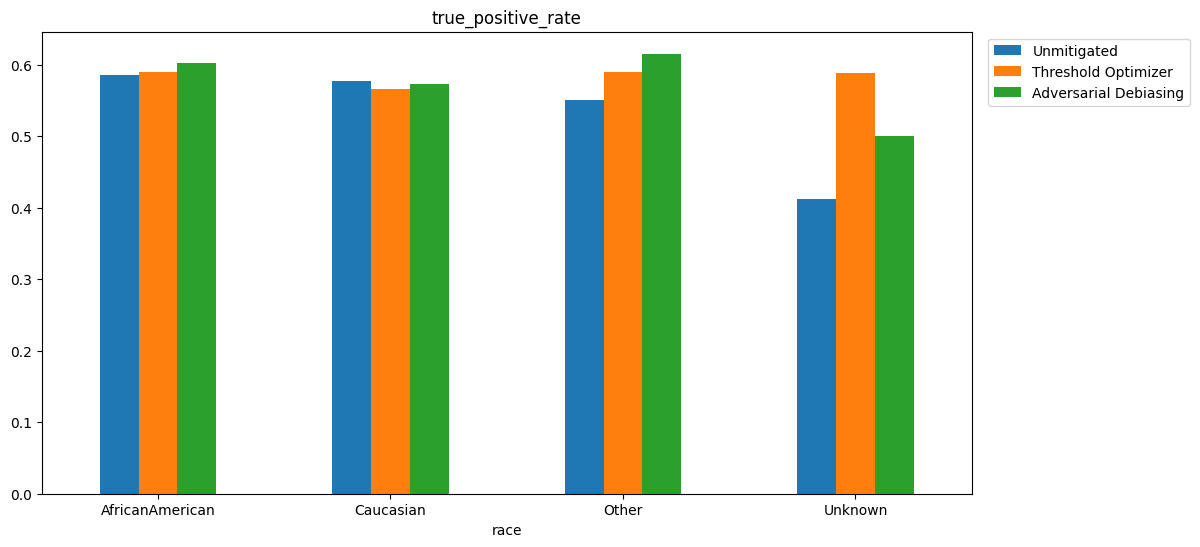

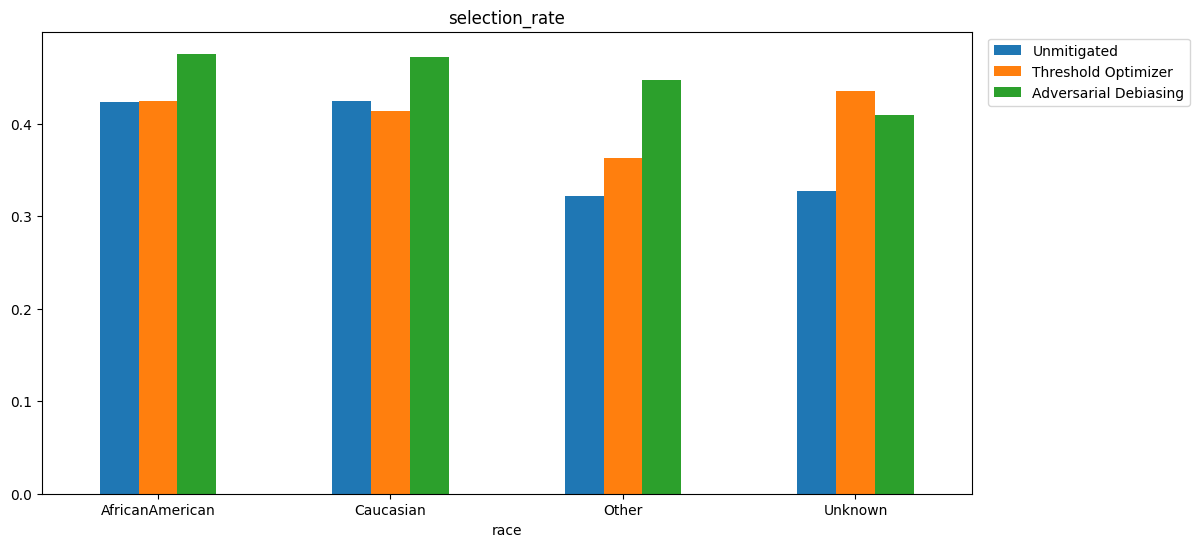

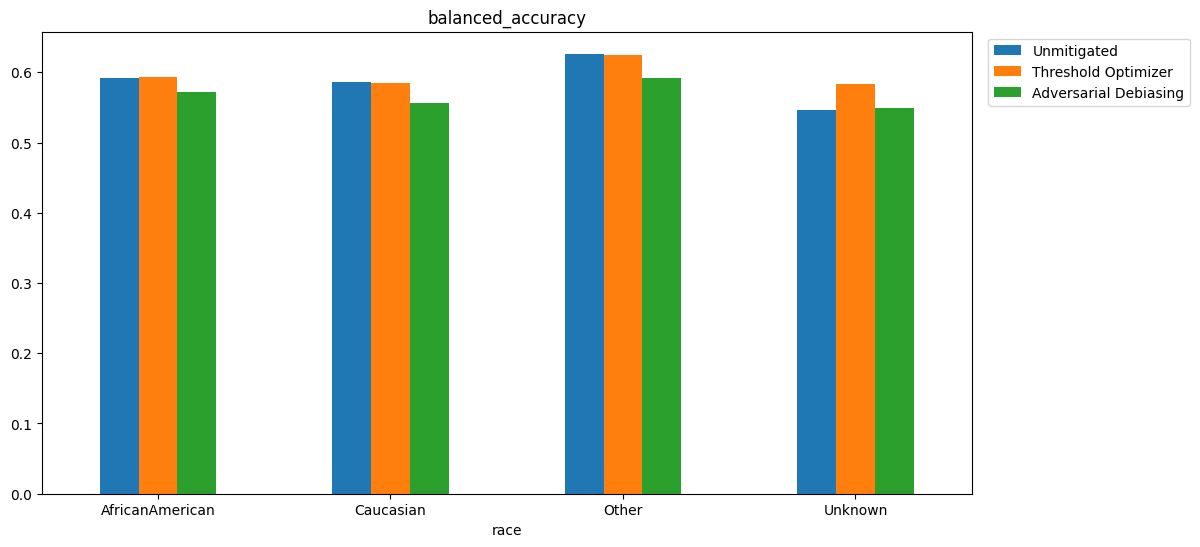

In [ ]:
plot_technique_comparison(test_dict, "true_positive_rate")
plot_technique_comparison(test_dict, "selection_rate")
plot_technique_comparison(test_dict, "balanced_accuracy")

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": decision_tree_mf.overall,
    "Threshold Optimizer": threshold_opt_mf.overall,
    "Adversarial Debiasing": adversarial_mf.overall
})

In [ ]:
overall_df.T

,true_positive_rate,balanced_accuracy,selection_rate
Unmitigated,0.575517,0.588306,0.418612
Threshold Optimizer,0.571554,0.588399,0.414484
Adversarial Debiasing,0.579040,0.561005,0.470643


array([[<Axes: title={'center': 'true_positive_rate'}>,
        <Axes: title={'center': 'balanced_accuracy'}>,
        <Axes: title={'center': 'selection_rate'}>]], dtype=object)

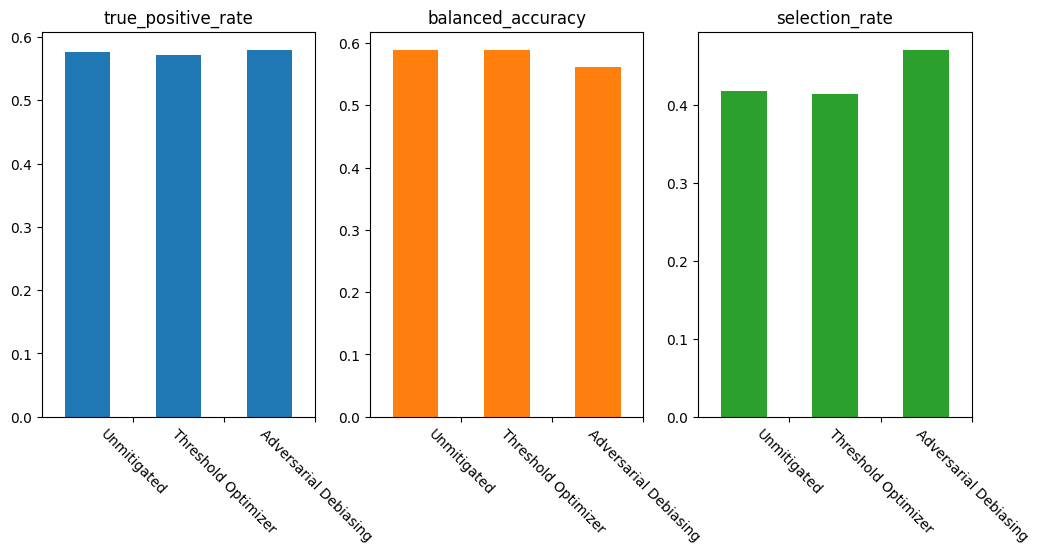

In [ ]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5)

In [ ]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": decision_tree_mf.difference(),
    "Threshold Optimizer": threshold_opt_mf.difference(),
    "Adversarial Debiasing": adversarial_mf.difference()
}
)

In [ ]:
difference_df.T

,true_positive_rate,balanced_accuracy,selection_rate
Unmitigated,0.173601,0.080471,0.103068
Threshold Optimizer,0.024227,0.041978,0.072206
Adversarial Debiasing,0.115385,0.043413,0.066424


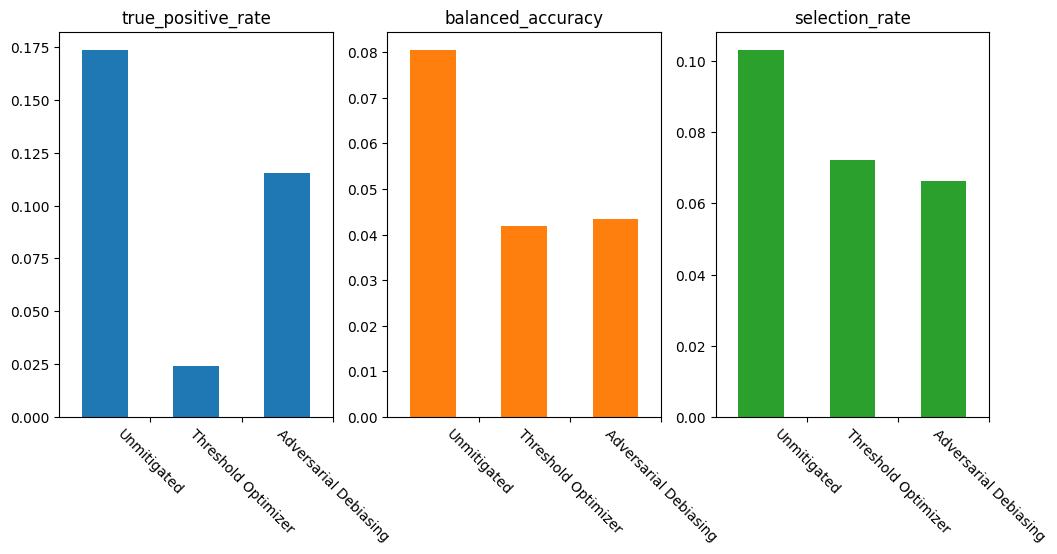

In [ ]:
difference_df.T.plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);